In [1]:
import itertools

import matplotlib.pyplot as plt
import numpy as np

import pandas as pd

import seisbench
import seisbench.data as sbd
import seisbench.generate as sbg

import obspy

from sklearn.model_selection import train_test_split

from tqdm.auto import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

In [2]:
device = 'cuda'

In [3]:
def l1(y, y_hat):
    return np.mean(np.abs(y-y_hat))

def convert_to_numeric(value):
    try:
        if type(value) != float:
            return min([float(i) for i in value[1:-1].split(" ")])
        else:
            return float(value)
    except (ValueError, TypeError):
        return np.nan

In [4]:
data = sbd.STEAD(sampling_rate=100)
print(data)

STEAD - 1265657 traces


In [5]:
data.metadata['trace_snr_db'] = data.metadata['trace_snr_db'].fillna(0).apply(convert_to_numeric)

In [6]:
mask_distance = data.metadata["source_distance_km"] < 110
mask_snr = data.metadata["trace_snr_db"] > 25

In [7]:
data.filter(mask_distance & mask_snr)
print(data)

STEAD - 190201 traces


In [8]:
pairs = data.metadata[['station_network_code', 'station_code', 'trace_channel', 'trace_component_order']].values.tolist()
pairs = list(set([tuple(i) for i in pairs]))
valid_pairs = []
invalid_pairs = []
client = obspy.clients.fdsn.Client("IRIS")
for network_code, station_code, channel, components in tqdm(pairs):
    try:
        alignment = {}
        for component in components:
            station_info = client.get_stations(network=network_code, station=station_code, channel=channel+component, level="channel")
            alignment[component] = station_info[0].stations[0].channels[0].azimuth

        north_aligned = abs(alignment['N'] - 360) % 360 < 2.5
        east_aligned = abs(alignment['E'] - 90) % 360 < 2.5

        if north_aligned and east_aligned:
            valid_pairs.append([network_code, station_code, channel, components])
        else:
            invalid_pairs.append([network_code, station_code, channel, components])
    except Exception as e:
        invalid_pairs.append([network_code, station_code, channel, components])

  0%|          | 0/2404 [00:00<?, ?it/s]

In [9]:
idxs = [data.metadata.query('station_network_code == @t[0] and station_code == @t[1] and trace_channel == @t[2] and trace_component_order == @t[3]').index.values for t in valid_pairs]
idxs = np.concatenate(idxs).ravel().tolist()

data.filter(data.metadata["index"].isin(idxs))

In [16]:
data.sampling_rate = 10

In [17]:
max_distance = data.metadata["source_distance_km"].max()
max_angle = data.metadata["source_distance_deg"].max()

min_distance = data.metadata["source_distance_km"].min()
min_angle = data.metadata["source_distance_deg"].min()

In [18]:
train, dev, test = data.train_dev_test()

In [19]:
class DistanceGenerator(sbg.GenericGenerator):
    def __getitem__(self, idx):
        state_dict = self._populate_state_dict(idx)

        for func in self._augmentations:
            func(state_dict)

        state_dict = self._clean_state_dict(state_dict)
        return state_dict

    def _clean_state_dict(self, state_dict):
        state_dict_waveform = {k: v[0].T for k, v in state_dict.items()}
        state_dict_output = {"y": torch.Tensor(np.array([(v[1]["source_distance_km"]-min_distance)/(max_distance-min_distance)])) for k, v in state_dict.items()}
                                                         #(v[1]["source_distance_deg"]-min_angle)/(max_angle-min_angle)])) for k, v in state_dict.items()}
        return {**state_dict_waveform, **state_dict_output}

In [20]:
train_generator = DistanceGenerator(train)
dev_generator = DistanceGenerator(dev)
test_generator = DistanceGenerator(test)

In [21]:
batch_size = 64

train_loader = DataLoader(train_generator, batch_size=batch_size, shuffle=True, drop_last=True)
dev_loader = DataLoader(dev_generator, batch_size=batch_size, shuffle=False, drop_last=True)
test_loader = DataLoader(test_generator, batch_size=batch_size, shuffle=True, drop_last=True)

In [ ]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv1d(in_channels=600, out_channels=512, kernel_size=4, dilation=1, padding='same'),
            nn.Tanh(), nn.Dropout(0.2),
            nn.Conv1d(in_channels=512, out_channels=256, kernel_size=4, dilation=2, padding='same'),
            nn.Tanh(), nn.Dropout(0.2),
            nn.Conv1d(in_channels=256, out_channels=128, kernel_size=4, dilation=4, padding='same'),
            nn.Tanh(), nn.Dropout(0.2),
            nn.Conv1d(in_channels=128, out_channels=64, kernel_size=4, dilation=8, padding='same')
        )
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(64*3, 1)

    def forward(self, x):
        #residual = x
        x = self.conv1(x)
        x = torch.relu(self.fc1(self.flatten(x)))
        return x

model = CNN().to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.75)

num_epochs = 5
for epoch in tqdm(range(num_epochs)):
    epoch_losses_distance = []
    for batch in (pbar:=tqdm(train_loader)):
        optimizer.zero_grad()
        outputs = model(batch['X'].to(device))
        loss = criterion(outputs, batch['y'].to(device))
        loss.backward()
        optimizer.step()
        distance_l1 = l1(outputs[:, 0].cpu().detach().numpy()*(max_distance-min_distance)+min_distance, 
                         batch['y'].detach().numpy()[:, 0]*(max_distance-min_distance)+min_distance)
        epoch_losses_distance.append(distance_l1)
        pbar.set_description("Loss: " + str(np.mean(epoch_losses_distance[-50:]))[:7])
    scheduler.step()

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1548 [00:00<?, ?it/s]

In [745]:
y = []
y_hat = []
losses_distance = []
for batch in tqdm(dev_loader):
    output = model.forward(batch['X'].to(device)).cpu().detach().numpy()
    y.extend(batch['y'].numpy())
    y_hat.extend(output)
    n_y_hat = outputs[:, 0].cpu().detach().numpy()*(max_distance-min_distance)+min_distance
    n_y = batch['y'].detach().numpy()[:, 0]*(max_distance-min_distance)+min_distance
    if n_y.shape == n_y_hat.shape:
        distance_l1 = l1(n_y_hat, n_y)
        losses_distance.append(distance_l1)

  0%|          | 0/89 [00:00<?, ?it/s]

In [746]:
y = np.array(y)
y_hat = np.array(y_hat)

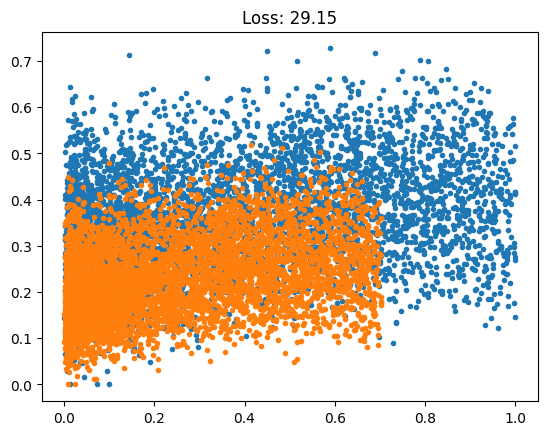

In [747]:
plt.scatter(y[:, 0], y_hat[:, 0], marker='.')
#plt.scatter(y[:, 1], y_hat[:, 1], marker='.')
plt.title("Loss: " + str(np.mean(losses_distance))[:5])
plt.show()